Dataset shape: (569, 30)
Target distribution:
 1    357
0    212
Name: count, dtype: int64
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

 

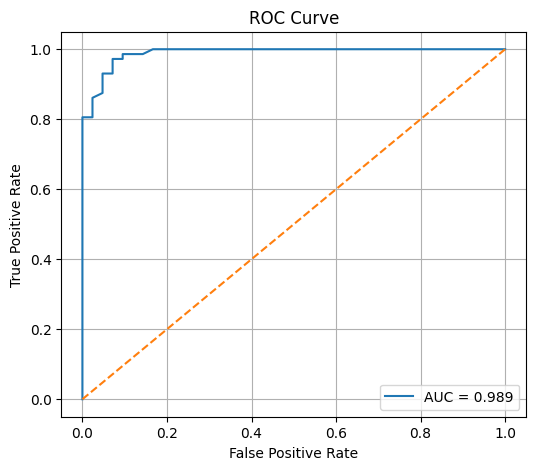

CV ROC AUC scores: [0.98264003 0.97510645 0.9985119  0.97800926 0.99597586]
Mean CV ROC AUC: 0.9860486996050376
Saved model to models/best_rf_kbest.joblib
Feature importances (from final model):
 worst perimeter         0.204197
worst concave points    0.197401
worst radius            0.150029
mean concave points     0.145360
worst area              0.129532
mean area               0.045294
mean concavity          0.034900
mean perimeter          0.032969
worst concavity         0.031839
mean radius             0.028481
dtype: float64
--- Summary ---
Selected features (k=10): ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']
Test ROC AUC: 0.9891
Model saved at: models/best_rf_kbest.joblib


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve,
                             roc_auc_score, accuracy_score, precision_score, recall_score)


data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts())


print(X.head())
print(X.describe().T.iloc[:, :5])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=10000, random_state=42))
])

baseline_pipe.fit(X_train, y_train)
base_preds = baseline_pipe.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, base_preds))
print(classification_report(y_test, base_preds))


k = 10
skb = SelectKBest(score_func=f_classif, k=k)
skb.fit(X_train, y_train)
mask = skb.get_support()
selected_features_kbest = X_train.columns[mask].tolist()
print(f"Top {k} features by SelectKBest:", selected_features_kbest)


rf_for_fs = RandomForestClassifier(n_estimators=200, random_state=42)
rf_for_fs.fit(X_train, y_train)
importances = pd.Series(rf_for_fs.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 10 features by tree importance:\n", importances.head(10))

X_train_k = X_train[selected_features_kbest]
X_test_k = X_test[selected_features_kbest]

pipe_kbest = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])
pipe_kbest.fit(X_train_k, y_train)
preds_k = pipe_kbest.predict(X_test_k)
print("Accuracy (Selected KBest features):", accuracy_score(y_test, preds_k))
print(classification_report(y_test, preds_k))


param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5]
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train_k, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)

best_model = gs.best_estimator_


y_pred = best_model.predict(X_test_k)
y_proba = best_model.predict_proba(X_test_k)[:, 1]

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


cv_scores = cross_val_score(best_model, X[selected_features_kbest], y, cv=5, scoring='roc_auc', n_jobs=-1)
print("CV ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC:", np.mean(cv_scores))


os.makedirs('models', exist_ok=True)
model_path = os.path.join('models', 'best_rf_kbest.joblib')
joblib.dump(best_model, model_path)
print(f"Saved model to {model_path}")


rf_in_pipe = best_model.named_steps['clf']
feat_importances = pd.Series(rf_in_pipe.feature_importances_, index=selected_features_kbest).sort_values(ascending=False)
print("Feature importances (from final model):\n", feat_importances)


print("--- Summary ---")
print(f"Selected features (k={k}): {selected_features_kbest}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("Model saved at:", model_path)
